## Setup
# PCA Cifar 5

In [7]:
##
## Restrict tensorflow to single GPU
##
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)           
## this says only use GPU 0  (can select 0-3)

##
## Import libraries
##
import evm_flat         ## We are using EVMs for a different project, so there are some things in here that may be confusing
from utils import *     ## utils holds a few functions I wrote to help with the experiments in this notebook
import numpy as np
import tensorflow as tf

##
## Experiment Parameters
##
epochs = 10               ## Iterations to train CNN for feature extractors
num_to_remove = 5           ## Number of classes to remove and make "unknown"
iterations = 30              ## Number of iterations (full experiments) to run
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  ## Confidence thresholds to evaluate over

##
## EVM Parameters (good initial values, but could be further optimized)
##
tailsize = 10000              ## EVM tail size
cover_threshold = 0.5      ## EVM cover threshold
dist_func = 'cosine'     ## EVM distance function
num_to_fuse = 4             ## EVM number to fuse
margin_scale = 0.5          ## EVM margin scale

## Data

In [8]:
##
## Load CiFar10
##
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
##
## Get data in correct shape and normalize
##
#x_train = x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))/255.0   ## Add dimension and normalize
#x_test = x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))/255.0         ## Add dimension and normalize
#y_train = tf.keras.utils.to_categorical(y_train)     ## Make one-hot
#y_test = tf.keras.utils.to_categorical(y_test)       ## Make one-hot

(50000, 32, 32, 3)


In [9]:
import keras.utils
y_train = tf.keras.utils.to_categorical(y_train) #one hot encode y vectors
y_test = tf.keras.utils.to_categorical(y_test)

y_train.shape

(50000, 10)

In [10]:
import random

shrink_x_train = np.asarray(x_train)
print(shrink_x_train.shape)
x_train_for_fit_index = np.random.choice(len(shrink_x_train), size = 15000, replace = False, p = None)

x_train_for_fit = shrink_x_train[x_train_for_fit_index]
x_train_for_fit.shape

(50000, 32, 32, 3)


(15000, 32, 32, 3)

## Create Feature Extractor With Perfect Knowledge 

- Feature extractor is a CNN trained using ALL of the classes
- This is not realistic in the real world because all of the classes will not be known
- This is a good "optimal" feature space to compare against
- Goal would be to get as close to this performance as possible

In [11]:
##
## Perfect Knowledge feature extractor
##
import plotly.express as plotex
from sklearn.decomposition import PCA


x_train_flattened = x_train_for_fit.reshape(15000,3072) #reshaping cube arrays into a flat vector 
#perfect_pca = PCA(svd_solver = 'full') #needs to be changed potentially with fancy graph information
perfect_pca = PCA(n_components = 128)
perfect_pca.fit(x_train_flattened)


exp_var_cumul = np.cumsum(perfect_pca.explained_variance_ratio_)

#print(exp_var_cumul)
#print(perfect_pca.explained_variance_ratio_)

#plotex.area(
#    x=range(1, exp_var_cumul.shape[0] + 1),
 #   y=exp_var_cumul,
  #  labels={"x": "# Components", "y": "Explained Variance"}
#)
#perfect_pca_features = perfect_pca.transform(x_train_flattened) #pca.transform(x_test.reshape(y, 3072)) <--- that would be testing for EVM 

In [12]:
#samp = [[.6], [.65], [.7]]
#pca_found = False
#index = 0 

#pca_index_list =[]

#print(exp_var_cumul.dtype)
#iter_exp_var_cumul = [exp_var_cumul]
#print(iter_exp_var_cumul)
#while pca_found == False:
#    for val in iter_exp_var_cumul:
#        for value in val:
#            index += 1
#            #print(value)
 #           if value > .9:
 #               pca_num = index - 1
 #               pca_index_list.append(pca_num)
#                #pca_found = True
#                print(pca_index_list[1])
            

In [13]:
#print(exp_var_cumul.dtype)
iter_exp_var_cumul = [exp_var_cumul]
#print(iter_exp_var_cumul)
index = -1

for val in iter_exp_var_cumul:
    for value in val:
        index += 1
        #print(value)
        if index == 127:
            print("128?")
            #pca_num = index - 1
            #pca_index_list.append(pca_num)
            #pca_found = True
            print(value)

128?
0.9195197488464034


## Define a set of experiments

- Randomly select and remove classes from the training data
- Split test data into known and unknown classes
- Fit imperfect feature extraction model
- Extract features using the perfect and imperfect extractors
- Fit EVM using features for the perfect and imperfect
- Evaluate performance (evaluation metrics may need to be improved, but this gives us an initial idea of performance)
- Repeat


In [15]:
##
import pandas as pd
## Define places to store results
##
imp_known_correct_all = []
imp_known_novel_all = []
imp_unknown_correct_all = []
imp_unknown_novel_all = []
per_known_correct_all = []
per_known_novel_all = []
per_unknown_correct_all = []
per_unknown_novel_all = []

df = pd.DataFrame(columns=['Iteration', 'Unknown Classes', 'imp_known_correct_all', 'imp_known_novel_all', 'imp_unknown_novel_all','per_known_correct_all','per_known_novel_all','per_unknown_novel_all'])

##
## Begin experiments
## imperfect cnn starts here
for i in range(iterations):
    print('Iteration: ' + str(i))
    print()
    
    ##
    ## Split the data into known and unknown classes
    ##
    toRemove = np.random.choice(10, num_to_remove, replace = False)                                         ## Randomly pick unknown classes
    x_train_known, x_train_unknown, y_train_known, y_train_unknown = split_data(x_train, y_train, toRemove) ## Split train data (defined in utils.py)
    x_test_known, x_test_unknown, y_test_known, y_test_unknown = split_data(x_test, y_test, toRemove)       ## Split test data (defined in utils.py)
   
    ##
    #df = df.append({'Iteration':i, 'Unknown Classes': toRemove}, ignore_index=True)
    #df.to_csv(r'./pca_df.csv', index=False,header=True)
    ## Train a classifier based feature extractor using only the known classes
    ##
   
    x_train_known=np.squeeze(x_train_known)
    
    #imperfect = feature_model(10-num_to_remove, x_train_known, y_train_known, epochs = epochs, batch_size = 32, verbose = 0)
    x_train_known_flattened = x_train_known.reshape(25000,3072) #reshaping cube arrays into a flat vector 
    imperfect_pca = PCA(n_components = 128) #needs to be changed potentially with fancy graph information
    imperfect_pca.fit(x_train_known_flattened)
    
    print(type(x_test_known))
    print(x_test_known.shape)
    x_test_known_flattened = x_test_known.reshape(5000,3072)
    x_test_unknown_flattened = x_test_unknown.reshape(5000,3072)
    #imperfect_pca_features = imperfect_pca.transform(x_train_flattened)
    ##
    ## Extract features with imperfect extractor
    ##
  
    x_train_known_imp = imperfect_pca.transform(x_train_known_flattened) #train EVM
    x_test_known_imp = imperfect_pca.transform(x_test_known_flattened) #Test EVM
    x_test_unknown_imp = imperfect_pca.transform(x_test_unknown_flattened) #Experimental test EVM

    ##
    x_train_known_imp = np.squeeze(x_train_known_imp)
    x_test_known_imp = np.squeeze(x_test_known_imp)
    x_test_unknown_imp = np.squeeze(x_test_unknown_imp)
    ## Extract features with perfect extractor
    ##
    x_train_known_per = perfect_pca.transform(x_train_known_flattened) #same but this time -- perfect
    x_test_known_per = perfect_pca.transform(x_test_known_flattened)
    x_test_unknown_per = perfect_pca.transform(x_test_unknown_flattened)

    ##
    x_train_known_per = np.squeeze(x_train_known_per)
    x_test_known_per = np.squeeze(x_test_known_per)
    x_test_unknown_per = np.squeeze(x_test_unknown_per)
    ## Fit EVMs
    ##
    evm_options = evm_flat.EVMOptions(tailsize = tailsize, cover_threshold = cover_threshold , dist_func = dist_func, num_to_fuse = num_to_fuse, margin_scale = margin_scale)
    
    print('Fit Imperfect EVM')
    evm_imp = evm_flat.ExtremeValueMachine('imperfect', evm_options)
    evm_imp.train(x_train_known_imp, y_train_known)
    print('Fit Perfect EVM')
    evm_per = evm_flat.ExtremeValueMachine('perfect', evm_options)
    evm_per.train(x_train_known_per, y_train_known)

    ##
    ## Make Predictions with EVM
    ##
    imp_pred_known = evm_imp.confidence(x_test_known_imp)
    imp_pred_unknown = evm_imp.confidence(x_test_unknown_imp)
    per_pred_known = evm_per.confidence(x_test_known_per)
    per_pred_unknown = evm_per.confidence(x_test_unknown_per)

    ##
    ## Evaluate Predictions
    ##
    imp_known_correct, imp_known_novel = eval(imp_pred_known, y_test_known, thresholds)           ## eval defined in utils.py
    imp_unknown_correct, imp_unknown_novel = eval(imp_pred_unknown, y_test_unknown, thresholds)
    per_known_correct, per_known_novel = eval(per_pred_known, y_test_known, thresholds)
    per_unknown_correct, per_unknown_novel = eval(per_pred_unknown, y_test_unknown, thresholds)
    
    ##
    ## Store results
    ##
    imp_known_correct_all.append(imp_known_correct)      ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
    imp_known_novel_all.append(imp_known_novel)          ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
    imp_unknown_novel_all.append(imp_unknown_novel)      ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
    per_known_correct_all.append(per_known_correct)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
    per_known_novel_all.append(per_known_novel)          ## per_known_novel: percentage of known instances called novel by the perfect EVM
    per_unknown_novel_all.append(per_unknown_novel)  
    ## per_unknown_novel: percentage of unknown instances called novel by the perfect EVM
    if i <= 5:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./pca_df_cf5_five_iter(s).csv', index= False,header=True)
        df.to_csv(r'./pca_df_cf5.csv', index= False,header=True)
    else:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./pca_df_cf5.csv', index= False,header=True)

Iteration: 0

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 1

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 2

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 3

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 4

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 5

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 6

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 7

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 8

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 9

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 10

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 11

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 12

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 13

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 14

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 15

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 16

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 17

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 18

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 19

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 20

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 21

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 22

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 23

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 24

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 25

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 26

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 27

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 28

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 29

<class 'numpy.ndarray'>
(5000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


In [ ]:
print(x_train_known_imp)
print(x_test_known_imp)
print(x_test_unknown_imp)

In [ ]:
print(imp_pred_known)
print(imp_pred_unknown)
print(per_pred_known)
print(per_pred_unknown)

In [16]:
#print(imp_known_correct_all)     ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
print(imp_known_novel_all)        ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
#print(imp_unknown_novel_all)     ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
#print(per_known_correct_all)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
#print(per_known_novel_all)         ## per_known_novel: percentage of known instances called novel by the perfect EVM
#print(per_unknown_novel_all)

[[0.0264, 0.095, 0.1738, 0.2602, 0.3544, 0.452, 0.5518, 0.6762, 0.8274, 1.0], [0.0254, 0.09, 0.1626, 0.2604, 0.3562, 0.4556, 0.5678, 0.6846, 0.8394, 1.0], [0.0252, 0.0832, 0.1512, 0.2266, 0.313, 0.403, 0.5016, 0.6334, 0.7974, 1.0], [0.023, 0.073, 0.1434, 0.2222, 0.3108, 0.4054, 0.51, 0.6262, 0.788, 1.0], [0.027, 0.098, 0.1792, 0.2634, 0.353, 0.4494, 0.5558, 0.6706, 0.8276, 1.0], [0.021, 0.0778, 0.1452, 0.2264, 0.3188, 0.4154, 0.521, 0.6454, 0.7942, 1.0], [0.0234, 0.0808, 0.1534, 0.2298, 0.3216, 0.4112, 0.512, 0.6264, 0.7776, 1.0], [0.0234, 0.0764, 0.1432, 0.2224, 0.3058, 0.4018, 0.4958, 0.6158, 0.7734, 0.9996], [0.0172, 0.0674, 0.1312, 0.2082, 0.2942, 0.3864, 0.487, 0.6236, 0.7896, 1.0], [0.0244, 0.07, 0.1392, 0.223, 0.3158, 0.4138, 0.526, 0.6406, 0.7908, 1.0], [0.0254, 0.0754, 0.1436, 0.225, 0.313, 0.4038, 0.519, 0.6358, 0.7804, 1.0], [0.0192, 0.0696, 0.1292, 0.2012, 0.2942, 0.386, 0.483, 0.6086, 0.773, 1.0], [0.0184, 0.061, 0.1196, 0.1856, 0.2636, 0.3468, 0.4442, 0.573, 0.7458, 1.0],

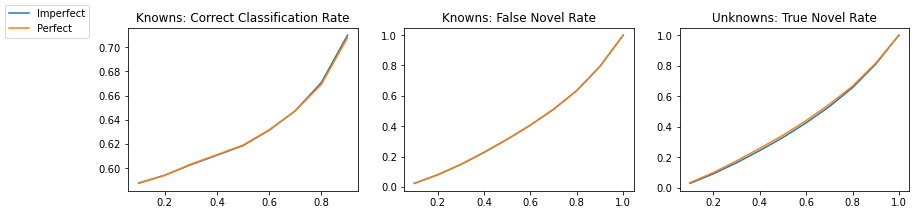

In [20]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize = (14, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Knowns: Correct Classification Rate')
ax2.title.set_text('Knowns: False Novel Rate')
ax3.title.set_text('Unknowns: True Novel Rate')

ax1.plot(thresholds, np.mean(imp_known_correct_all, axis = 0), label = 'Imperfect')
ax1.plot(thresholds, np.mean(per_known_correct_all, axis = 0), label = 'Perfect')


ax2.plot(thresholds, np.mean(imp_known_novel_all, axis = 0), label = 'Imperfect')
ax2.plot(thresholds, np.mean(per_known_novel_all, axis = 0), label = 'Perfect')

ax3.plot(thresholds, np.mean(imp_unknown_novel_all, axis = 0), label = 'Imperfect')
ax3.plot(thresholds, np.mean(per_unknown_novel_all, axis = 0), label = 'Perfect')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.savefig('PCA_images_cf5_30iter.pdf')
plt.show()

In [ ]:
x_train_known_imp.shape